In [143]:
# import Necessary modules
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from matplotlib import pyplot as plt


In [144]:
# Load dataset
data = pd.read_csv('price_prediction.csv')

In [146]:
# Data preprocessing
data.columns = [c.replace(' ', '_').lower() for c in data.columns]
features = ['engine_hp', 'engine_cylinders', 'transmission_type', 'driven_wheels',
            'number_of_doors', 'market_category', 'vehicle_size', 'vehicle_style',
            'highway_mpg', 'city_mpg', 'popularity']
X = pd.get_dummies(data[features], drop_first=True)
y = data['msrp']

In [147]:
# One-hot encoding for categorical variables
X = pd.get_dummies(X, drop_first=True)


In [148]:
# Ensure all column names are strings after one-hot encoding
X.columns = X.columns.astype(str)

In [149]:
# Handling missing data
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

In [150]:
# Handling outliers
z_scores = np.abs((X - X.mean()) / X.std())
X, y = X[(z_scores < 3).all(axis=1)], y[(z_scores < 3).all(axis=1)]


In [151]:
# Feature selection using backward elimination
X = sm.add_constant(X)  # Add a constant for statsmodels
model = sm.OLS(y, X).fit()
while max(model.pvalues) > 0.05:
    X.drop(X.columns[np.argmax(model.pvalues)], axis=1, inplace=True)
    model = sm.OLS(y, X).fit()


In [135]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [152]:
# Initialize models with default parameters
default_models = {
    "Linear Regression": LinearRegression(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor()
}


In [153]:
# Train and predict with each default model
default_predictions = {}
for name, model in default_models.items():
    model.fit(X_train, y_train)
    default_predictions[name] = model.predict(X_test)


In [154]:
# Evaluate each default model
default_evaluations = {}
for name, pred in default_predictions.items():
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    default_evaluations[name] = (mae, mse, r2)
    print(f"{name} - Default - MAE: {mae:.2f}, MSE: {mse:.2f}, R-squared: {r2:.4f}")

Linear Regression - Default - MAE: 4626.13, MSE: 36606305.48, R-squared: 0.7486
K-Nearest Neighbors - Default - MAE: 2972.22, MSE: 23100478.38, R-squared: 0.8413
Decision Tree - Default - MAE: 2158.41, MSE: 11308328.53, R-squared: 0.9223


In [156]:
# Tuning the models
tuned_models = {
    "K-Nearest Neighbors": GridSearchCV(KNeighborsRegressor(), {'n_neighbors': range(1, 20)}, cv=5, scoring='r2'),
    "Decision Tree": GridSearchCV(DecisionTreeRegressor(), {'max_depth': range(1, 20), 'min_samples_split': range(2, 20), 'min_samples_leaf': range(1, 10)}, cv=5, scoring='r2'),
    "Linear Regression": GridSearchCV(Ridge(), {'alpha': [0.01, 0.1, 1, 10, 100]}, cv=5, scoring='r2')
}




In [ ]:
# Train and predict with each tuned model
tuned_predictions = {}
for name, model in tuned_models.items():
    model.fit(X_train, y_train)
    tuned_predictions[name] = model.predict(X_test)

In [ ]:
# Evaluate each tuned model
tuned_evaluations = {}
for name, pred in tuned_predictions.items():
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    tuned_evaluations[name] = (mae, mse, r2)
    print(f"{name} - Tuned - MAE: {mae:.2f}, MSE: {mse:.2f}, R-squared: {r2:.4f}")

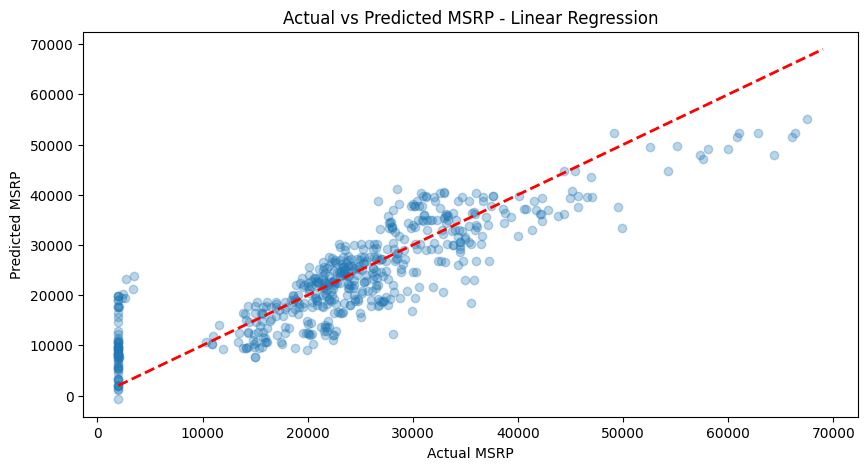

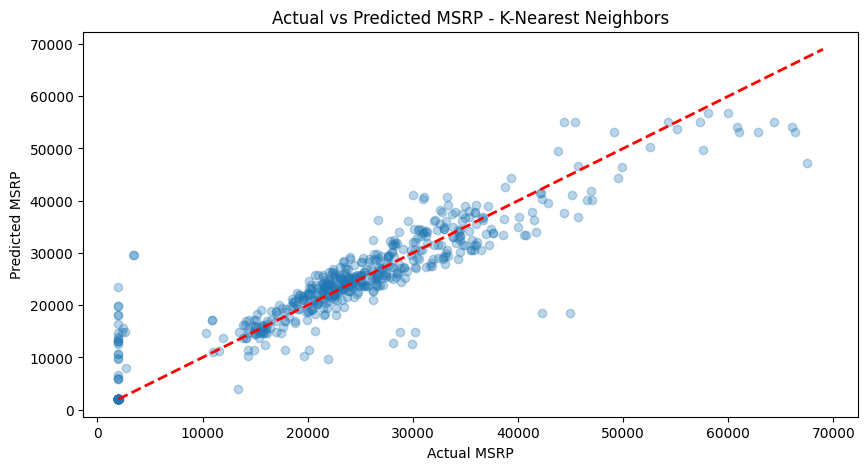

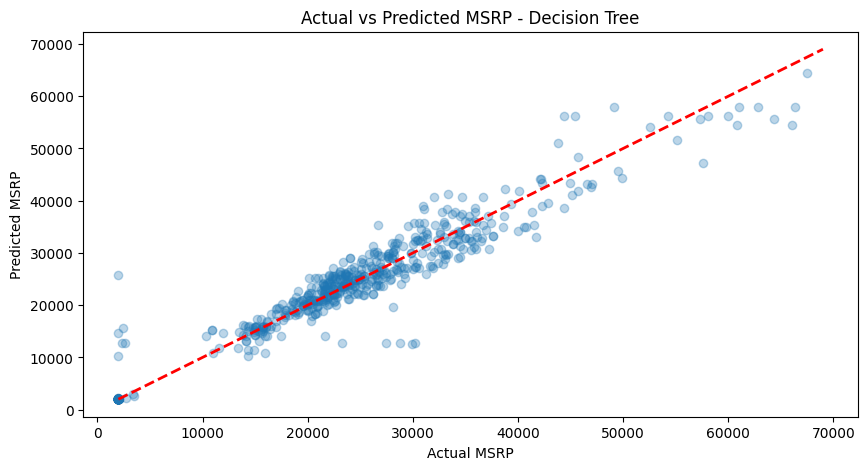

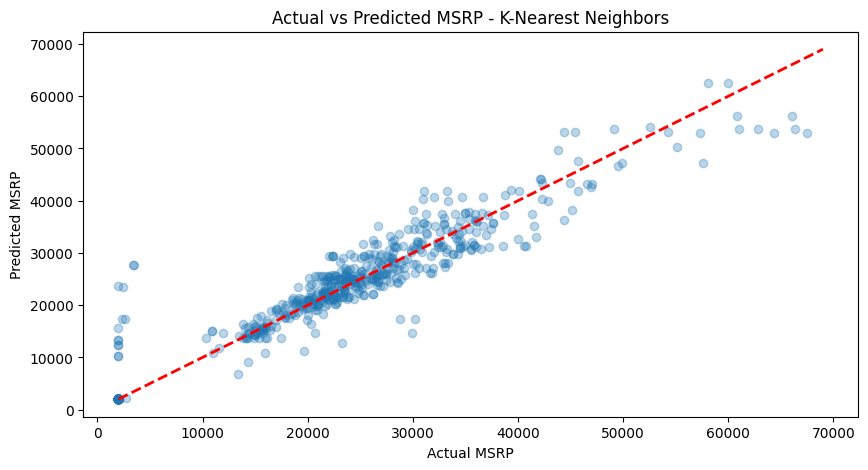

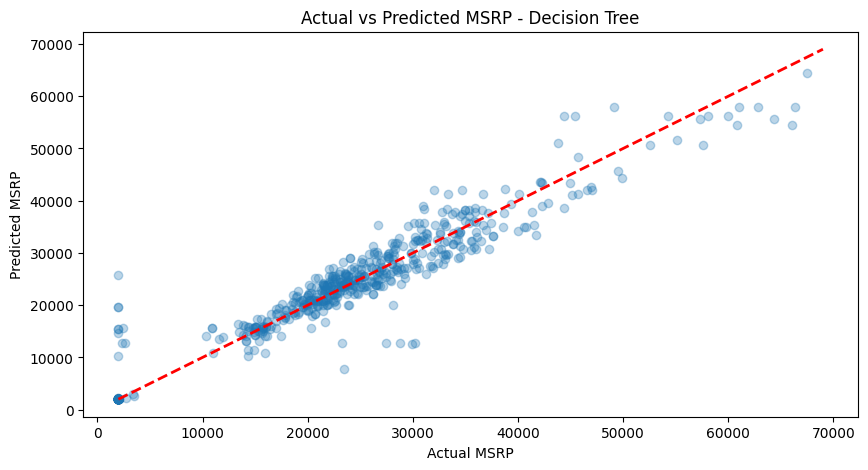

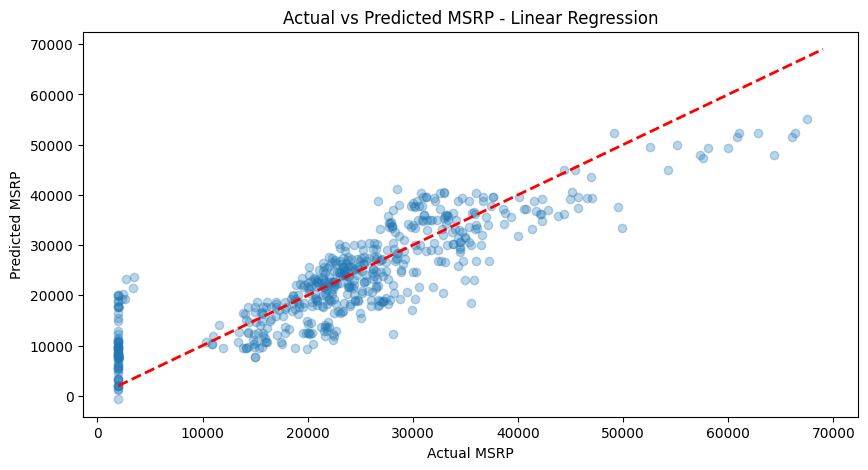

In [142]:
def plot_results(predictions):
    for name, pred in predictions.items():
        plt.figure(figsize=(10, 5))
        plt.scatter(y_test, pred, alpha=0.3)
        plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
        plt.xlabel('Actual MSRP')
        plt.ylabel('Predicted MSRP')
        plt.title(f'Actual vs Predicted MSRP - {name}')
        plt.show()

# Optionally, plot results for both default and tuned models
plot_results(default_predictions)
plot_results(tuned_predictions)
